In [53]:
import os

import numpy as np
from sklearn.linear_model import LogisticRegression

from tqdm import tqdm

import matplotlib
import matplotlib.pyplot as plt

from utils import load_hidden_representations_from_hdf5, read_templates_from_file

----

In [2]:
# params
log_dir = "/logfiles"
model = "bigscience-T0_3B"
module = "decoder"
task = "rte"

In [3]:
# assertions
assert model == "bigscience-T0_3B"
assert module == "decoder"
assert task == "rte"

## Prompts

In [4]:
df = read_templates_from_file(f"/t0-analysis/prompts/{task}/all.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_prompt.csv")
# df = read_templates_from_file(f"/t0-analysis/prompts/{task}/fixed_target_yes_no.csv")
display(df)

,name,template,category,includes_targets,targets,target_ids,shuffle
0,gpt_3_yes_no_with_targets,{premise} Question: {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
1,mnli_crowdsource_with_targets,"{premise} Using only the above description and what you know about the world, is ""{hypothesis}"" definitely correct? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
2,based_on_previous_passage_with_targets,"{premise} Based on the previous passage, is it true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
3,infer_with_targets,"Suppose {premise} Can we infer that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
4,follow_with_targets,Given that {premise} Does it follow that {hypothesis} Yes or No?,instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
5,imply_with_targets,"{premise} Question: Does this imply that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
6,guaranteed_with_targets,"Given {premise} Is it guaranteed true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
7,justified_with_targets,"{premise} Are we justified in saying that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
8,must_be_true_with_targets,"Given that {premise} Therefore, it must be true that ""{hypothesis}""? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False
9,should_assume_with_targets,"Given {premise} Should we assume that ""{hypothesis}"" is true? Yes or No?",instructive,True,"▁Yes, ▁No, ▁yes, ▁no","0, 1, 0, 1",False


## Train linear classifier

In [5]:
def unison_shuffled_copies(a, b):
    # from: https://stackoverflow.com/questions/4601373/better-way-to-shuffle-two-numpy-arrays-in-unison
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [8]:
use_pattern = [
    "gpt_3_yes_no_with_targets",
    "mnli_crowdsource_with_targets",
    # "based_on_previous_passage_with_targets",
    # "infer_with_targets",
    # "follow_with_targets",
    # "imply_with_targets",
    # "guaranteed_with_targets",
    # "justified_with_targets",
    # "must_be_true_with_targets",
    # "should_assume_with_targets",
    # "gpt_3_true_false_with_targets",
    # "gpt_3_cat_dog_with_targets",
    # "gpt_3_cat_dog_with_targets_yes_no",
    # "gpt_3_yes_no_without_targets",
    # "words_appear_with_targets",
    # "similar_words_with_targets",
    # "start_with_the_with_targets",
    # "same_meaning_with_targets",
    # "paraphrase_with_targets",
    # "paraphrase_r_with_targets",
    # "summarize_with_targets",
    # "inflection_with_targets",
    # "null_pattern_with_targets",
    # "null_pattern_r_with_targets",
    # "null_pattern_without_targets",
    # "null_pattern_r_without_targets",
    # "premise_only_with_targets",
    # "premise_only_without_targets",
    # "hypothesis_only_with_targets",
    # "hypothesis_only_without_targets",
    # "sentiment_with_targets",
    # "sentiment_cat_dog_with_targets"
]

In [75]:
layer_accs, first_n_dims = {}, {}

for t in range(1):
    # for layer in tqdm(range(1, 5), desc="layers"):
    # for layer in tqdm(range(1, 5), desc="layers"):
    for layer in tqdm(range(20, 25), desc="layers"):

        layer_accs[layer] = []
        first_n_dims[layer] = []
        
        # print(f"token: {t}\tlayer: {layer}")
        file_names, prompt_names = [], []

        for _, row in df.iterrows():
            if row['name'] in use_pattern:
                file_names.append(f"{task}/{model}/{module}/{row['name']}/hidden_represenations_t{t}_layer{layer}_avg.hdf5",)
                prompt_names.append(row['name'])


        for dims in range(2, 100):
            # load hidden representations from hdf5 file
            representations = None
            classes = []
            n_sequences = 0
            first_n_dims[layer].append(dims)

            for idx, file_name in enumerate(file_names):
                hidden_representations = load_hidden_representations_from_hdf5(os.path.join(log_dir, file_name), silent=True)
                hidden_representations = hidden_representations[:, :dims]
                n_sequences = hidden_representations.shape[0]

                if representations is None:
                    representations = hidden_representations
                else:
                    representations = np.concatenate((representations, hidden_representations), axis=0)

                classes += n_sequences * [idx] # assign representations to classes
            
            classes = np.asarray(classes)

            # shuffle representations and classes
            X, y = unison_shuffled_copies(representations, classes)
            # print(X.shape, y.shape)

            # train linear classifier
            # multi_class='multinomial' uses a CE loss
            # print('classifying between:', prompt_names)
            clf = LogisticRegression(random_state=0, max_iter=2000, multi_class='multinomial').fit(X, y)
            acc = clf.score(X, y)
            layer_accs[layer].append(acc)
            # print(f'token={t}; layer={layer}; dim={dims}; accuracy on training data: ', acc)
            # print('')



layers: 100%|██████████| 5/5 [01:15<00:00, 15.08s/it]


In [76]:
layer_accs.keys()

dict_keys([20, 21, 22, 23, 24])

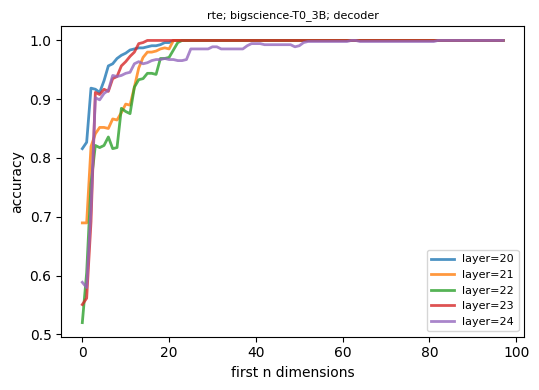

In [78]:
# plot results
fig, axes = plt.subplots(1, 1, figsize=(5.5,4), dpi=100)
for l in layer_accs.keys():
    axes.plot(layer_accs[l], alpha=0.8, linewidth=2, label=f"layer={l}")

    axes.set_xlabel("first n dimensions")
    # axes.set_xticks(np.arange(2, first_n_dims[l][-1] + 1, 10))
    # axes.set_xticklabels(np.arange(2, first_n_dims[l][-1] + 1, 10))
    axes.set_ylabel("accuracy")

axes.legend(loc="best", fontsize=8)
axes.set_title(f"{task}; {model}; {module}", fontsize=8)
plt.tight_layout();